In [1]:
import numpy as np

import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import torchattacks

import ddn.pytorch.robustpool as robustpool
import ddn.pytorch.projections as projections

import neptune

import urllib
from urllib.request import urlretrieve
from pathlib import Path

# import pytorch_lightning as pl

%matplotlib inline
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from IPython.display import clear_output

from model import RobustPoolSqueezeNet
from util import calculate_accuracy, calculate_accuracy_dataset


random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [2]:
DATASET_ROOT = Path("Architectural_Heritage_Elements_Dataset_128_splitted")
ARCHIVE_NAME = Path("Architectural_Heritage_Elements_Dataset_128_splitted.zip")

N_CLASSES = 10

if not ARCHIVE_NAME.is_file():
    print("Downloading...")
    urlretrieve(
        "https://dl.dropboxusercontent.com/s/bucvr9x6ypqjht2/Architectural_Heritage_Elements_Dataset_128_splitted.zip",
        ARCHIVE_NAME)

if not DATASET_ROOT.is_dir():
    print("Unzipping...")
    import zipfile
    with zipfile.ZipFile(ARCHIVE_NAME, 'r') as archive:
        archive.extractall(".")

train_dataset = torchvision.datasets.ImageFolder(DATASET_ROOT / "train", transform=transforms.ToTensor())
test_dataset = torchvision.datasets.ImageFolder(DATASET_ROOT / "test", transform=transforms.ToTensor())

In [3]:
def attack_model(model, dataset, attack, batch_size):
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=4, shuffle=False)
    
    n_correct = 0
    n_predictions = 0
    
    for image_batch, label_batch in loader:
        
        image_batch = image_batch.to(DEVICE)
        label_batch = label_batch.to(DEVICE)
        adversarial_images = attack(image_batch, label_batch)
        
        with torch.no_grad():
            y_pred = torch.argmax(model.forward(adversarial_images), dim=1)
            n_correct += (y_pred == label_batch).sum().item()
            n_predictions += label_batch.shape[0]
            
    return n_correct / n_predictions


def fgsm_attack(model, dataset, epsilon, batch_size):
    attack = torchattacks.FGSM(model, eps=epsilon)
    return attack_model(model, dataset, attack, batch_size)


def gaussian_noise_attack(model, dataset, sigma, batch_size):
    attack = torchattacks.GN(model, sigma=sigma)
    return attack_model(model, dataset, attack, batch_size)


def deep_fool_attack(model, dataset, steps, batch_size):
    attack = torchattacks.DeepFool(model, steps=steps)
    return attack_model(model, dataset, attack, batch_size)


def evaluate_robustness(robust_type, alpha, dataset, attack_fn, attack_params, batch_size=256):
    model = RobustPoolSqueezeNet(N_CLASSES, robust_type, alpha)
    model = model.to(DEVICE)
    model.load_state_dict(torch.load("checkpoints/" + model.get_model_name() + ".pth.tar"))
    model = model.eval()

    basic_acc = calculate_accuracy_dataset(model, dataset, batch_size, DEVICE)
    print("Initial accuracy: " + str(basic_acc))
    attack_accs = []
    for param in tqdm(attack_params):
        acc = attack_fn(model, dataset, param, batch_size)
        print("Param: " + str(param) + ", accuracy: " + str(acc))
        attack_accs.append(acc)
    return basic_acc, np.array(attack_accs)

In [4]:
sigmas = np.array([0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5])
epsilons = np.array([0.05, 0.1, 0.15, 0.2, 0.25, 0.3])

## Basic model

In [5]:
vanilla_acc, vanilla_attack_accs = evaluate_robustness("vanilla", 1.0, test_dataset, 
                                                       gaussian_noise_attack, sigmas)
vanilla_factors = vanilla_attack_accs / vanilla_acc

Initial accuracy: 0.749390541199415


Param: 0.01, accuracy: 0.7484154071184788
Param: 0.05, accuracy: 0.6811311555338859
Param: 0.1, accuracy: 0.3983422720624086
Param: 0.15, accuracy: 0.16284739151633348
Param: 0.2, accuracy: 0.12140419307654803
Param: 0.3, accuracy: 0.10092637737688932
Param: 0.5, accuracy: 0.10092637737688932



## Quadratic pooling, Gaussian noise

### alpha = 1.0

In [32]:
alpha = 1.0

robust_acc, robust_attack_accs = evaluate_robustness("quadratic", alpha, test_dataset, 
                                                     gaussian_noise_attack, sigmas)
robust_factors = robust_attack_accs / robust_acc

Initial accuracy: 0.7396392003900536


Param: 0.01, accuracy: 0.7411019015114578
Param: 0.05, accuracy: 0.704534373476353
Param: 0.1, accuracy: 0.5616772306192102
Param: 0.15, accuracy: 0.3515358361774744
Param: 0.2, accuracy: 0.2257435397367138
Param: 0.3, accuracy: 0.12384202827888835
Param: 0.5, accuracy: 0.10092637737688932



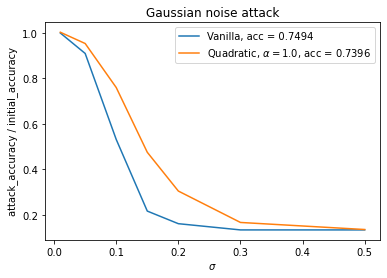

In [33]:
plt.plot(sigmas, vanilla_factors, label="Vanilla, acc = " + str(round(vanilla_acc, 4)))
plt.plot(sigmas, robust_factors, label="Quadratic, $\\alpha = " + str(alpha) + "$, acc = " + str(round(robust_acc, 4)))
plt.xlabel("$\sigma$")
plt.ylabel("attack_accuracy / initial_accuracy")
plt.title("Gaussian noise attack")
plt.legend()
plt.show()

### alpha = 0.5

In [34]:
alpha = 0.5

robust_acc, robust_attack_accs = evaluate_robustness("quadratic", alpha, test_dataset, 
                                                     gaussian_noise_attack, sigmas)
robust_factors = robust_attack_accs / robust_acc

Initial accuracy: 0.7581667479278401


Param: 0.01, accuracy: 0.7601170160897124
Param: 0.05, accuracy: 0.7357386640663092
Param: 0.1, accuracy: 0.5953193564115066
Param: 0.15, accuracy: 0.33057045343734764
Param: 0.2, accuracy: 0.1340809361287177
Param: 0.3, accuracy: 0.10092637737688932
Param: 0.5, accuracy: 0.10092637737688932



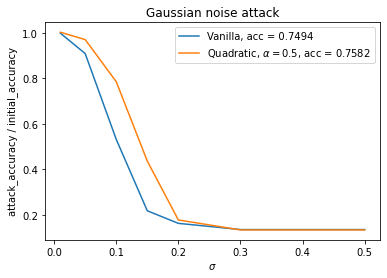

In [35]:
plt.plot(sigmas, vanilla_factors, label="Vanilla, acc = " + str(round(vanilla_acc, 4)))
plt.plot(sigmas, robust_factors, label="Quadratic, $\\alpha = " + str(alpha) + "$, acc = " + str(round(robust_acc, 4)))
plt.xlabel("$\sigma$")
plt.ylabel("attack_accuracy / initial_accuracy")
plt.title("Gaussian noise attack")
plt.legend()
plt.show()

### alpha = 0.2

In [36]:
alpha = 0.2

robust_acc, robust_attack_accs = evaluate_robustness("quadratic", alpha, test_dataset, 
                                                     gaussian_noise_attack, sigmas)
robust_factors = robust_attack_accs / robust_acc

Initial accuracy: 0.7435397367137981


Param: 0.01, accuracy: 0.7401267674305217
Param: 0.05, accuracy: 0.7059970745977572
Param: 0.1, accuracy: 0.5602145294978059
Param: 0.15, accuracy: 0.3676255485129205
Param: 0.2, accuracy: 0.24183325207215992
Param: 0.3, accuracy: 0.16723549488054607
Param: 0.5, accuracy: 0.14285714285714285



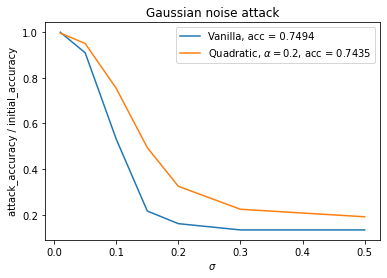

In [37]:
plt.plot(sigmas, vanilla_factors, label="Vanilla, acc = " + str(round(vanilla_acc, 4)))
plt.plot(sigmas, robust_factors, label="Quadratic, $\\alpha = " + str(alpha) + "$, acc = " + str(round(robust_acc, 4)))
plt.xlabel("$\sigma$")
plt.ylabel("attack_accuracy / initial_accuracy")
plt.title("Gaussian noise attack")
plt.legend()
plt.show()

### alpha = 0.05

In [38]:
alpha = 0.05

robust_acc, robust_attack_accs = evaluate_robustness("quadratic", alpha, test_dataset, 
                                                     gaussian_noise_attack, sigmas)
robust_factors = robust_attack_accs / robust_acc

Initial accuracy: 0.757679180887372


Param: 0.01, accuracy: 0.7567040468064359
Param: 0.05, accuracy: 0.7411019015114578
Param: 0.1, accuracy: 0.6260360799609946
Param: 0.15, accuracy: 0.4324719648951731
Param: 0.2, accuracy: 0.2793759141882009
Param: 0.3, accuracy: 0.15260848366650415
Param: 0.5, accuracy: 0.10726474890297416



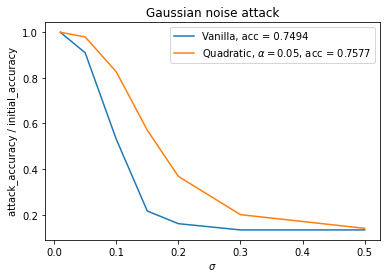

In [39]:
plt.plot(sigmas, vanilla_factors, label="Vanilla, acc = " + str(round(vanilla_acc, 4)))
plt.plot(sigmas, robust_factors, label="Quadratic, $\\alpha = " + str(alpha) + "$, acc = " + str(round(robust_acc, 4)))
plt.xlabel("$\sigma$")
plt.ylabel("attack_accuracy / initial_accuracy")
plt.title("Gaussian noise attack")
plt.legend()
plt.show()

### alpha = 1.5

In [40]:
alpha = 1.5

robust_acc, robust_attack_accs = evaluate_robustness("quadratic", alpha, test_dataset, 
                                                     gaussian_noise_attack, sigmas)
robust_factors = robust_attack_accs / robust_acc

Initial accuracy: 0.7489029741589469


Param: 0.01, accuracy: 0.7552413456850317
Param: 0.05, accuracy: 0.6869819600195027
Param: 0.1, accuracy: 0.4763529985372989
Param: 0.15, accuracy: 0.2764505119453925
Param: 0.2, accuracy: 0.18917601170160897
Param: 0.3, accuracy: 0.12384202827888835
Param: 0.5, accuracy: 0.10190151145782544



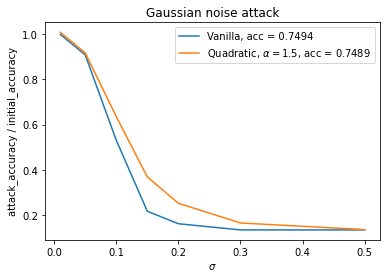

In [41]:
plt.plot(sigmas, vanilla_factors, label="Vanilla, acc = " + str(round(vanilla_acc, 4)))
plt.plot(sigmas, robust_factors, label="Quadratic, $\\alpha = " + str(alpha) + "$, acc = " + str(round(robust_acc, 4)))
plt.xlabel("$\sigma$")
plt.ylabel("attack_accuracy / initial_accuracy")
plt.title("Gaussian noise attack")
plt.legend()
plt.show()

## Quadratic, FGSM attack

In [42]:
vanilla_acc, vanilla_attack_accs = evaluate_robustness("vanilla", 1.0, test_dataset, 
                                                       fgsm_attack, epsilons)
vanilla_factors = vanilla_attack_accs / vanilla_acc

Initial accuracy: 0.749390541199415


Param: 0.05, accuracy: 0.113603120429059
Param: 0.1, accuracy: 0.12091662603607996
Param: 0.15, accuracy: 0.10433934666016577
Param: 0.2, accuracy: 0.10141394441735739
Param: 0.25, accuracy: 0.10092637737688932
Param: 0.3, accuracy: 0.10092637737688932



### alpha = 1.0

In [43]:
alpha = 1.0

robust_acc, robust_attack_accs = evaluate_robustness("quadratic", alpha, test_dataset, 
                                                     fgsm_attack, epsilons)
robust_factors = robust_attack_accs / robust_acc

Initial accuracy: 0.7396392003900536


Param: 0.05, accuracy: 0.09946367625548513
Param: 0.1, accuracy: 0.14822038030229157
Param: 0.15, accuracy: 0.14383227693807898
Param: 0.2, accuracy: 0.11652852267186738
Param: 0.25, accuracy: 0.10433934666016577
Param: 0.3, accuracy: 0.10190151145782544



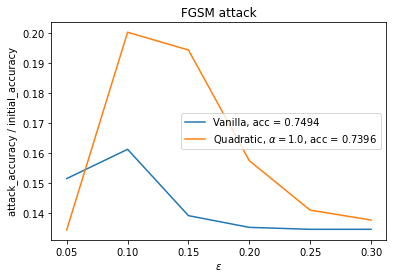

In [44]:
plt.plot(epsilons, vanilla_factors, label="Vanilla, acc = " + str(round(vanilla_acc, 4)))
plt.plot(epsilons, robust_factors, label="Quadratic, $\\alpha = " + str(alpha) + "$, acc = " + str(round(robust_acc, 4)))
plt.xlabel("$\epsilon$")
plt.ylabel("attack_accuracy / initial_accuracy")
plt.title("FGSM attack")
plt.legend()
plt.show()

### alpha = 0.5

In [45]:
alpha = 0.5

robust_acc, robust_attack_accs = evaluate_robustness("quadratic", alpha, test_dataset, 
                                                     fgsm_attack, epsilons)
robust_factors = robust_attack_accs / robust_acc

Initial accuracy: 0.7581667479278401


Param: 0.05, accuracy: 0.14480741101901512
Param: 0.1, accuracy: 0.15650901999024866
Param: 0.15, accuracy: 0.12286689419795221
Param: 0.2, accuracy: 0.10287664553876158
Param: 0.25, accuracy: 0.10092637737688932
Param: 0.3, accuracy: 0.10092637737688932



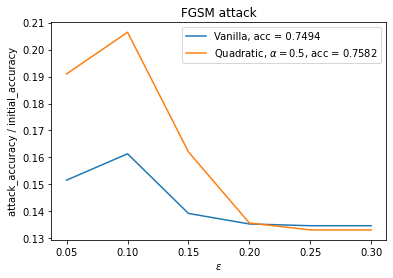

In [46]:
plt.plot(epsilons, vanilla_factors, label="Vanilla, acc = " + str(round(vanilla_acc, 4)))
plt.plot(epsilons, robust_factors, label="Quadratic, $\\alpha = " + str(alpha) + "$, acc = " + str(round(robust_acc, 4)))
plt.xlabel("$\epsilon$")
plt.ylabel("attack_accuracy / initial_accuracy")
plt.title("FGSM attack")
plt.legend()
plt.show()

### alpha = 0.2

In [47]:
alpha = 0.2

robust_acc, robust_attack_accs = evaluate_robustness("quadratic", alpha, test_dataset, 
                                                     fgsm_attack, epsilons)
robust_factors = robust_attack_accs / robust_acc

Initial accuracy: 0.7435397367137981


Param: 0.05, accuracy: 0.10092637737688932
Param: 0.1, accuracy: 0.11165285226718674
Param: 0.15, accuracy: 0.12237932715748416
Param: 0.2, accuracy: 0.10482691370063384
Param: 0.25, accuracy: 0.098488542174549
Param: 0.3, accuracy: 0.09751340809361288



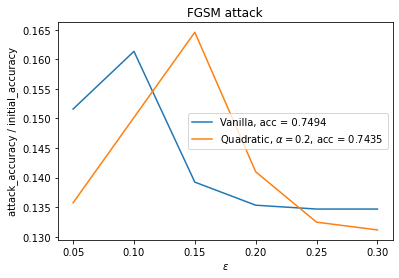

In [49]:
plt.plot(epsilons, vanilla_factors, label="Vanilla, acc = " + str(round(vanilla_acc, 4)))
plt.plot(epsilons, robust_factors, label="Quadratic, $\\alpha = " + str(alpha) + "$, acc = " + str(round(robust_acc, 4)))
plt.xlabel("$\epsilon$")
plt.ylabel("attack_accuracy / initial_accuracy")
plt.title("FGSM attack")
plt.legend()
plt.show()

### alpha = 0.05

In [50]:
alpha = 0.05

robust_acc, robust_attack_accs = evaluate_robustness("quadratic", alpha, test_dataset, 
                                                     fgsm_attack, epsilons)
robust_factors = robust_attack_accs / robust_acc

Initial accuracy: 0.757679180887372


Param: 0.05, accuracy: 0.08678693320331546
Param: 0.1, accuracy: 0.12920526572403707
Param: 0.15, accuracy: 0.113603120429059
Param: 0.2, accuracy: 0.09995124329595319
Param: 0.25, accuracy: 0.10043881033642126
Param: 0.3, accuracy: 0.10092637737688932



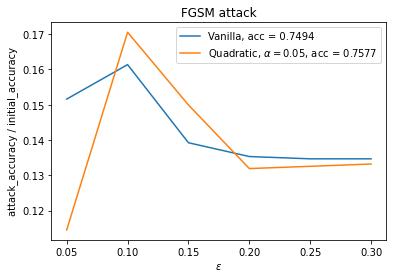

In [51]:
plt.plot(epsilons, vanilla_factors, label="Vanilla, acc = " + str(round(vanilla_acc, 4)))
plt.plot(epsilons, robust_factors, label="Quadratic, $\\alpha = " + str(alpha) + "$, acc = " + str(round(robust_acc, 4)))
plt.xlabel("$\epsilon$")
plt.ylabel("attack_accuracy / initial_accuracy")
plt.title("FGSM attack")
plt.legend()
plt.show()

### alpha = 1.5

In [52]:
alpha = 1.5

robust_acc, robust_attack_accs = evaluate_robustness("quadratic", alpha, test_dataset, 
                                                     fgsm_attack, epsilons)
robust_factors = robust_attack_accs / robust_acc

Initial accuracy: 0.7489029741589469


Param: 0.05, accuracy: 0.09458800585080449
Param: 0.1, accuracy: 0.1394441735738664
Param: 0.15, accuracy: 0.12286689419795221
Param: 0.2, accuracy: 0.10433934666016577
Param: 0.25, accuracy: 0.09946367625548513
Param: 0.3, accuracy: 0.09946367625548513



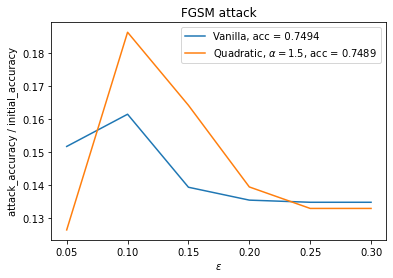

In [53]:
plt.plot(epsilons, vanilla_factors, label="Vanilla, acc = " + str(round(vanilla_acc, 4)))
plt.plot(epsilons, robust_factors, label="Quadratic, $\\alpha = " + str(alpha) + "$, acc = " + str(round(robust_acc, 4)))
plt.xlabel("$\epsilon$")
plt.ylabel("attack_accuracy / initial_accuracy")
plt.title("FGSM attack")
plt.legend()
plt.show()

## Pseudo-Huber, Gaussian Noise

In [54]:
vanilla_acc, vanilla_attack_accs = evaluate_robustness("vanilla", 1.0, test_dataset, 
                                                       gaussian_noise_attack, sigmas)
vanilla_factors = vanilla_attack_accs / vanilla_acc

Initial accuracy: 0.749390541199415


Param: 0.01, accuracy: 0.7484154071184788
Param: 0.05, accuracy: 0.6811311555338859
Param: 0.1, accuracy: 0.4037055095075573
Param: 0.15, accuracy: 0.1613846903949293
Param: 0.2, accuracy: 0.12189176011701609
Param: 0.3, accuracy: 0.10092637737688932
Param: 0.5, accuracy: 0.10092637737688932



## alpha = 1.0

In [55]:
alpha = 1.0

robust_acc, robust_attack_accs = evaluate_robustness("pseudo-huber", alpha, test_dataset, 
                                                     gaussian_noise_attack, sigmas)
robust_factors = robust_attack_accs / robust_acc

Initial accuracy: 0.7381764992686495


Param: 0.01, accuracy: 0.7415894685519259
Param: 0.05, accuracy: 0.7157484154071185
Param: 0.1, accuracy: 0.5426621160409556
Param: 0.15, accuracy: 0.3130180399804973
Param: 0.2, accuracy: 0.1696733300828864
Param: 0.3, accuracy: 0.10287664553876158
Param: 0.5, accuracy: 0.10092637737688932



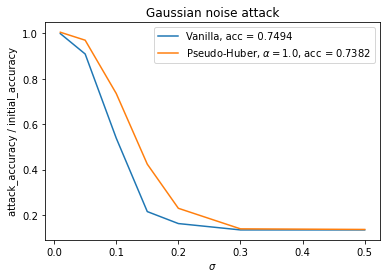

In [56]:
plt.plot(sigmas, vanilla_factors, label="Vanilla, acc = " + str(round(vanilla_acc, 4)))
plt.plot(sigmas, robust_factors, label="Pseudo-Huber, $\\alpha = " + str(alpha) + "$, acc = " + str(round(robust_acc, 4)))
plt.xlabel("$\sigma$")
plt.ylabel("attack_accuracy / initial_accuracy")
plt.title("Gaussian noise attack")
plt.legend()
plt.show()

### alpha = 0.5

In [57]:
alpha = 0.5

robust_acc, robust_attack_accs = evaluate_robustness("pseudo-huber", alpha, test_dataset, 
                                                     gaussian_noise_attack, sigmas)
robust_factors = robust_attack_accs / robust_acc

Initial accuracy: 0.7367137981472452


Param: 0.01, accuracy: 0.7323256947830327
Param: 0.05, accuracy: 0.7074597757191614
Param: 0.1, accuracy: 0.552901023890785
Param: 0.15, accuracy: 0.3003412969283277
Param: 0.2, accuracy: 0.1326182350073135
Param: 0.3, accuracy: 0.10092637737688932
Param: 0.5, accuracy: 0.10092637737688932



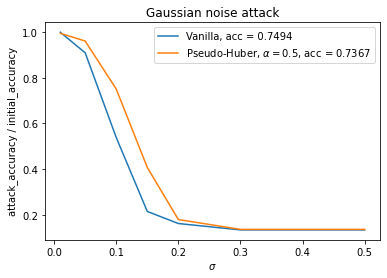

In [58]:
plt.plot(sigmas, vanilla_factors, label="Vanilla, acc = " + str(round(vanilla_acc, 4)))
plt.plot(sigmas, robust_factors, label="Pseudo-Huber, $\\alpha = " + str(alpha) + "$, acc = " + str(round(robust_acc, 4)))
plt.xlabel("$\sigma$")
plt.ylabel("attack_accuracy / initial_accuracy")
plt.title("Gaussian noise attack")
plt.legend()
plt.show()

### alpha = 0.2

In [59]:
alpha = 0.2

robust_acc, robust_attack_accs = evaluate_robustness("pseudo-huber", alpha, test_dataset, 
                                                     gaussian_noise_attack, sigmas)
robust_factors = robust_attack_accs / robust_acc

Initial accuracy: 0.6338371526084836


Param: 0.01, accuracy: 0.5543637250121892
Param: 0.05, accuracy: 0.5777669429546562
Param: 0.1, accuracy: 0.4519746465138957
Param: 0.15, accuracy: 0.26474890297415893
Param: 0.2, accuracy: 0.128717698683569
Param: 0.3, accuracy: 0.11457825450999512
Param: 0.5, accuracy: 0.098488542174549



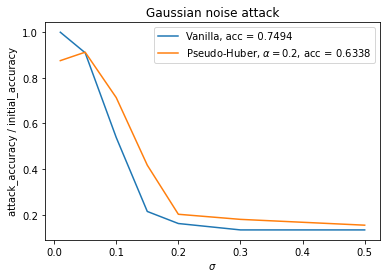

In [60]:
plt.plot(sigmas, vanilla_factors, label="Vanilla, acc = " + str(round(vanilla_acc, 4)))
plt.plot(sigmas, robust_factors, label="Pseudo-Huber, $\\alpha = " + str(alpha) + "$, acc = " + str(round(robust_acc, 4)))
plt.xlabel("$\sigma$")
plt.ylabel("attack_accuracy / initial_accuracy")
plt.title("Gaussian noise attack")
plt.legend()
plt.show()

### alpha = 0.05

In [61]:
alpha = 0.05

robust_acc, robust_attack_accs = evaluate_robustness("pseudo-huber", alpha, test_dataset, 
                                                     gaussian_noise_attack, sigmas)
robust_factors = robust_attack_accs / robust_acc

Initial accuracy: 0.25889809848854217


Param: 0.01, accuracy: 0.2598732325694783
Param: 0.05, accuracy: 0.24183325207215992
Param: 0.1, accuracy: 0.21111652852267188
Param: 0.15, accuracy: 0.18576304241833252
Param: 0.2, accuracy: 0.15699658703071673
Param: 0.3, accuracy: 0.12042905899561189
Param: 0.5, accuracy: 0.10823988298391028



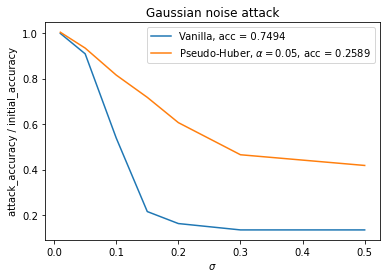

In [62]:
plt.plot(sigmas, vanilla_factors, label="Vanilla, acc = " + str(round(vanilla_acc, 4)))
plt.plot(sigmas, robust_factors, label="Pseudo-Huber, $\\alpha = " + str(alpha) + "$, acc = " + str(round(robust_acc, 4)))
plt.xlabel("$\sigma$")
plt.ylabel("attack_accuracy / initial_accuracy")
plt.title("Gaussian noise attack")
plt.legend()
plt.show()

### alpha = 1.5

In [63]:
alpha = 1.5

robust_acc, robust_attack_accs = evaluate_robustness("pseudo-huber", alpha, test_dataset, 
                                                     gaussian_noise_attack, sigmas)
robust_factors = robust_attack_accs / robust_acc

Initial accuracy: 0.7459775719161384


Param: 0.01, accuracy: 0.7430521696733301
Param: 0.05, accuracy: 0.6640663091175036
Param: 0.1, accuracy: 0.46757679180887374
Param: 0.15, accuracy: 0.2745002437835202
Param: 0.2, accuracy: 0.1657727937591419
Param: 0.3, accuracy: 0.10628961482203803
Param: 0.5, accuracy: 0.10092637737688932



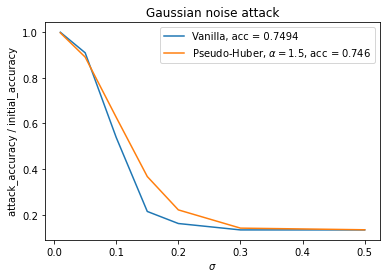

In [64]:
plt.plot(sigmas, robust_factors, label="Pseudo-Huber, $\\alpha = " + str(alpha) + "$, acc = " + str(round(robust_acc, 4)))
plt.xlabel("$\sigma$")
plt.ylabel("attack_accuracy / initial_accuracy")
plt.title("Gaussian noise attack")
plt.legend()
plt.show()

## Pseudo-Huber, FGSM attack